In [4]:
%pip install pytorch3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.3/901.3 kB 898.3 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import sys
import random
import random
import itertools

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import orthogonal_procrustes
from pytorch3d.transforms import euler_angles_to_matrix, matrix_to_euler_angles, random_rotation
from pytorch3d.transforms import quaternion_to_matrix
from pytorch3d import transforms
from pytorch3d.transforms import rotation_conversions as rc
import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)})

from solver import Up2P
from utils.rotation_utils import validate_sol, get_rotation_error, get_upward_with_dev, get_random_upward

In [2]:
# config
from dataclasses import dataclass

@dataclass
class Config:
    max_depth: float = 10.
    img_width: int = 640
    img_height: int = 640
    focal_length: int = 3 * (img_width * 0.5) / np.tan(60.0 * np.pi / 180.0);
    min_depth: float = 1.
    max_depth: float = 1.1
    inliers_ratio: float = 1.
    outlier_dist: float = 30.
    
    # [TODO][IMPORTNAT]: not properly tested, be aware of using for
    # some experiments
    pixel_noise: float = 0.
    
conf = Config()
print(conf)

Config(max_depth=1.1, img_width=640, img_height=640, focal_length=554.2562584220409, min_depth=1.0, inliers_ratio=1.0, outlier_dist=30.0, pixel_noise=0.0)


In [3]:
dtype = torch.float64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def get_random_image_point(conf: Config):
    x = random.uniform(0, conf.img_width)
    y = random.uniform(0, conf.img_height)
    x = torch.tensor([x, y], dtype=torch.float64)    
    return x

def to_homogeneous(x):
    return torch.cat([x, torch.ones(1)])

def to_camera_coords(x: torch.tensor, conf: Config = conf):
    x = to_homogeneous(x)
    
    x[0] -= conf.img_width // 2
    x[1] -= conf.img_height // 2
    x[:2] /= conf.focal_length
    x /= x.norm()
    
    return x

def generate_correspondence(x: torch.tensor, conf: Config):
    x = to_camera_coords(x, conf)
    x *= random.uniform(conf.min_depth, conf.max_depth)
    
    assert x.shape == (3,)    
    return x

def transform_correspondence(X: torch.tensor, R: torch.tensor, t: torch.tensor):
    return R @ X + t

def _generate_example(R, t, conf: Config = conf):
    x1, x2 = get_random_image_point(conf), get_random_image_point(conf)
    X1, X2 = generate_correspondence(x1.clone(), conf),\
             generate_correspondence(x2.clone(), conf)
    X1, X2 = transform_correspondence(X1, R, t), transform_correspondence(X2, R, t)
    
    # [TODO][IMPORTNAT]: not properly tested, be aware of using for
    # some experiments
    if conf.pixel_noise != 0:
        x1noise = np.random.normal(0, conf.pixel_noise, 2)
        x2noise = np.random.normal(0, conf.pixel_noise, 2)
        
        if torch.all(x1[0] + x1noise > 0) and torch.all(x1[1] + x1noise < conf.img_width):
            x1 += x1noise
            assert x1[0] > 0 and x1[1] < conf.img_width, f"{x1}"
            
        if torch.all(x2[0] + x2noise > 0) and torch.all(x2[1] + x2noise < conf.img_height):
            x2 += x2noise
            assert x2[0] > 0 and x2[1] < conf.img_height, f"{x2}"
        
        assert x1[0] > 0 and x1[1] < conf.img_width, f"{x1}"
        assert x2[0] > 0 and x2[1] < conf.img_height, f"{x2}"

    return x1, x2, X1, X2 

# x: [2, ]
def generate_outlier(x, conf):
    out = get_random_image_point(conf)
    
    while ((out - x).norm() < conf.outlier_dist):
        out = get_random_image_point(conf)
        
    return out

from typing import Tuple
def generate_examples(num_of_examples: int,
                      dev: Tuple[float, float] = (0., 0.), conf: Config = conf):
    num_of_examples = num_of_examples // 2
    
    num_inliers = num_of_examples * conf.inliers_ratio
    num_outliers = num_of_examples - num_inliers
    
    if num_of_examples == 0:
        num_of_examples, num_inliers, num_outliers = 1, 1, 0
    
    R, rand_angle = get_random_upward(*dev)
    t = torch.rand(3, )
        
    # [TODO] [IMPORTANT]: under such generation we cannot get model where one of the points is an inlier
    xs, Xs, inliers = [], [], []
    for i in range(num_of_examples):
        x1, x2, X1, X2 = _generate_example(R, t)
        Xs.append((X1, X2))
        
        if i < num_inliers:
            xs.append((x1, x2))
            inliers.append(True)
        else:
            xs.append((generate_outlier(x1, conf), generate_outlier(x2, conf)))
            inliers.append(False)
            
    return xs, Xs, inliers, R, t, rand_angle

In [5]:
# X : (3, )
# R : (3, 3) - rotation matrix
# t : (3, ) - translation vector
def reproject(X, R, t, conf: Config = conf):
    translated = R.T @ (X - t)
    translated[:2] /= translated[2]
    translated[:2] *= conf.focal_length
    translated[0] += conf.img_width // 2
    translated[1] += conf.img_height // 2
    
    return translated[:2]

In [6]:
from solver import Up2P
def assert_correctness():
    solver = Up2P()
    xs, Xs, _, Rg, tg, _ = generate_examples(1)
    print(Rg, tg)
    xs, Xs = xs[0], Xs[0]
    Re, te, err = None, None, None
    
    xsc = torch.zeros((2, 3))
    xsc[0] = to_camera_coords(xs[0], conf)
    xsc[1] = to_camera_coords(xs[1], conf)
    
    for R, t in solver(xsc, torch.stack(Xs)):
        rerr, terr = validate_sol(R, t, Rg, tg)
        print(t, tg)
        print(f"--------- R error: {rerr}, t error: {terr} ----------")  
        if err is None or rerr < err:
            err = rerr
            Re, te = R, t
            
    print(Re)
    print(xs[0])
    print(reproject(Xs[0], Re, te, conf))
    assert torch.all(torch.isclose(xs[0], reproject(Xs[0], Re, te, conf)))
        
assert_correctness()

tensor([[ 0.9986,  0.0000,  0.0523],
        [ 0.0000,  1.0000,  0.0000],
        [-0.0523,  0.0000,  0.9986]], dtype=torch.float64) tensor([0.3227, 0.4598, 0.0180])
tensor([0.3227, 0.4598, 0.0180], dtype=torch.float64) tensor([0.3227, 0.4598, 0.0180])
--------- R error: 0.009809146105878514, t error: 3.855287340063264e-08 ----------
tensor([0.1843, 1.0581, 0.0489], dtype=torch.float64) tensor([0.3227, 0.4598, 0.0180])
--------- R error: 172.2466301120393, t error: 0.6148544407919966 ----------
tensor([[ 0.9986,  0.0000,  0.0523],
        [ 0.0000,  1.0000,  0.0000],
        [-0.0523,  0.0000,  0.9986]], dtype=torch.float64)
tensor([377.6566, 479.0000], dtype=torch.float64)
tensor([377.6566, 479.0000], dtype=torch.float64)


In [7]:
def one_sided_to_beginning(xs):
    good_indices = []
    good_xs = []
    bad_xs = []
    bad_indices = []
    
    for idx, (x1, x2) in enumerate(xs):
        if x1[0] < conf.img_width // 2 and x2[0] > conf.img_width // 2:
            good_xs.append((x1, x2))
            good_indices.append(idx)
        elif x1[0] > conf.img_width // 2 and x2[0] < conf.img_width // 2:
            good_xs.append((x1, x2))
            good_indices.append(idx)
        else:
            bad_xs.append((x1, x2))
            bad_indices.append(idx)
            
    new_xs = good_xs + bad_xs
    new_indices = good_indices + bad_indices
    
    assert len(new_xs) == len(xs)
    assert len(new_indices) == len(xs)
    
    return new_xs, new_indices, len(good_xs)

def sort_by_pair_point_dist(xs: torch.Tensor,
                            Xs: torch.Tensor,
                            inliers: torch.Tensor
                           ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    sorted_pts = sorted(zip(xs, range(len(xs))),
                            key=lambda x: (x[0][0] - x[0][1]).norm(),
                            reverse=True)
    xs = [elm[0] for elm in sorted_pts]
    idcs_for_sorted = [elm[1] for elm in sorted_pts]
    Xs = [Xs[i] for i in idcs_for_sorted]
    inliers = [inliers[i] for i in idcs_for_sorted]
    
    return xs, Xs, inliers

def sort_by_one_side(xs: torch.Tensor,
                     Xs: torch.Tensor,
                     inliers: torch.Tensor
                    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    xs, permutation, len_one_sided = one_sided_to_beginning(xs)
    Xs = [Xs[i] for i in permutation]
    inliers = [inliers[i] for i in permutation]
    
    return xs, Xs, inliers, len_one_sided

def get_displacements(n: int = 52, dev: Tuple[float, float] = (0, 0),
                      points_for_solver: str = "random", conf: Config = conf):
    solver = Up2P()
    
    generated_from_inlier: bool = True
    xs, Xs, inliers, Rg, tg, rand_angle = generate_examples(n, dev)

    if points_for_solver in ("max-dist", "min-dist"):
        xs, Xs, inliers = sort_by_pair_point_dist(xs, Xs, inliers)
    elif points_for_solver in ("one-side", "diff-side"):
        xs, Xs, inliers, len_one_sided = sort_by_one_side(xs, Xs, inliers)
    
    xsc = [(to_camera_coords(x[0].clone(), conf), to_camera_coords(x[1].clone(), conf)) for x in xs]

    solve_for = None
    sols = []
    
    # print("Rg:", Rg)
    
    try_number = -1
    while len(sols) == 0:
        try_number += 1
        if points_for_solver == "random":
            solve_for = random.randint(0, len(xsc) - 1)
        elif points_for_solver == "max-dist":
            solve_for = try_number
        elif points_for_solver == "min-dist":
            solve_for = len(xsc) - 1 - try_number
        elif points_for_solver == "one-side":
            if len_one_sided <= try_number:
                raise ValueError()
            solve_for = try_number
        elif points_for_solver == "diff-side":
            if len_one_sided <= try_number:
                raise ValueError()
            solve_for = len(xsc) - 1 - try_number
        else:
            raise NotImplemented()
        sols = solver(torch.stack(xsc[solve_for]), torch.stack(Xs[solve_for]))
        # print(sols)
        
    if not inliers[solve_for]:
        generated_from_inlier = False
    
    validate_for = None
    while validate_for is None or validate_for == solve_for:
        validate_for = random.randint(0, len(xsc) - 1)
    
    R, t, err = None, None, None
    for sol in sols:
        Rc, tc = sol
        reprojected_x = reproject(Xs[validate_for][0], Rc, tc)
        gt_x = xs[validate_for][0]
        
        # print(reprojected_x, gt_x)
        if err is None or (gt_x - reprojected_x).norm() < err:
            err = (gt_x - reprojected_x).norm()
            R, t = Rc, tc
            
            
    solved_y = torch.rad2deg(rc.matrix_to_euler_angles(R, "XYZ"))[1]
            
    reprojected_x = reproject(Xs[validate_for][0], R, t)
    gt_x = xs[validate_for][0]
    
    # print("err: ",  err)
    if dev == (0, 0) and generated_from_inlier:
        # print(err)
        assert err < 5e-2
        assert (gt_x - reprojected_x).norm() < 5e-2
    
    gt, proj, disp, inlier_disp = [], [], [], []
    
    for idx in range(len(Xs)):
        if idx == solve_for or idx == validate_for:
            continue
            
        inlier_disp.append(inliers[idx])
        for j in range(2):
            X, x = Xs[idx][j], xs[idx][j]
            reprojected_x = reproject(X, R, t)
            
            if dev == (0, 0) and generated_from_inlier:
                assert (x[:2] - reprojected_x[:2]).norm() < 1e-2, f"{(x[:2] - reprojected_x[:2]).norm()}"

            disp.append(x[:2] - reprojected_x[:2])
            gt.append(x[:2])
            proj.append(reprojected_x[:2])
        
    return gt, proj, disp, inlier_disp, rand_angle, solved_y, generated_from_inlier

In [8]:
# TODO: run this for inliers with zero dev as test that everyghin works ok
# for i in tqdm(range(100)):
#     try:
#         _ = get_displacements(100, (0,  0))
#     except Exception as ex:
#         print(ex)

In [9]:
import matplotlib.patches as patches

def plot_displacements(gt, proj, inlier_disp, conf):
    assert len(gt) == len(proj)
    assert len(gt)//2 == len(inlier_disp)
    
    # TODO: //2 is hacky, may introduce a bug later on
    
    good_idcs, bad_idcs = [], []
    for i in range(len(gt)):
        if inlier_disp[i // 2]:
            good_idcs.append(i)
        else:
            bad_idcs.append(i)
            
    X = np.array([float(elm[0]) for elm in gt])
    Y = np.array([float(elm[1]) for elm in gt])
    U = np.array([float(elm[0]) - X[idx] for idx, elm in enumerate(proj)])
    V = np.array([float(elm[1]) - Y[idx] for idx, elm in enumerate(proj)])

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25, 16), dpi=80)
    axes.plot(U + X, V + Y, marker='.', color='r', linestyle='none', markersize=7)
    axes.plot(X, Y, marker='*', color='b', linestyle='none', markersize=5)
    
    rect = patches.Rectangle((0, 0), conf.img_width, conf.img_height, linewidth=1, edgecolor='r', facecolor='none')
    axes.add_patch(rect)
        
    axes.quiver(X[good_idcs], Y[good_idcs], U[good_idcs], V[good_idcs],
                           color='b',
                           units='xy',
                           angles='xy',
                           scale_units='xy',
                           width=3,
                           scale=1,
                          )


    axes.quiver(X[bad_idcs], Y[bad_idcs], U[bad_idcs], V[bad_idcs],
                           color='y',
                           units='xy',
                           angles='xy',
                           scale_units='xy',
                           width=3,
                           scale=1,
                          )
    
    axes.quiver(np.mean(X[good_idcs]), np.mean(Y[good_idcs]), np.mean(U[good_idcs]), np.mean(V[good_idcs]),
                           color='g',
                           units='xy',
                           angles='xy',
                           scale_units='xy',
                           width=3,
                           scale=1,
                          )
    
    axes.quiver(np.mean(X[bad_idcs]), np.mean(Y[bad_idcs]), np.mean(U[bad_idcs]), np.mean(V[bad_idcs]),
                           color='r',
                           units='xy',
                           angles='xy',
                           scale_units='xy',
                           width=3,
                           scale=1,
                          )
    
    bh, _ = axes.plot([], [], [], color="b", label="Inlier displacements")
    yh, _ = axes.plot([], [], [], color="y", label="Oulier displacements")
    gh, _ = axes.plot([], [], [], color="g", label="Mean inlier displacement")
    rh, _ = axes.plot([], [], [], color="r", label="Mean outlier displacement")
    
    plt.legend(handles=[bh, yh, gh, rh])
    axes.set_xlim(-0.5 * conf.img_width, 1.5 * conf.img_width)
    axes.set_ylim(-0.5 * conf.img_height, 1.5 * conf.img_height)

    plt.show()

[True] y_gen angle is: tensor([60.]), y_pred: 57.63478543404539


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


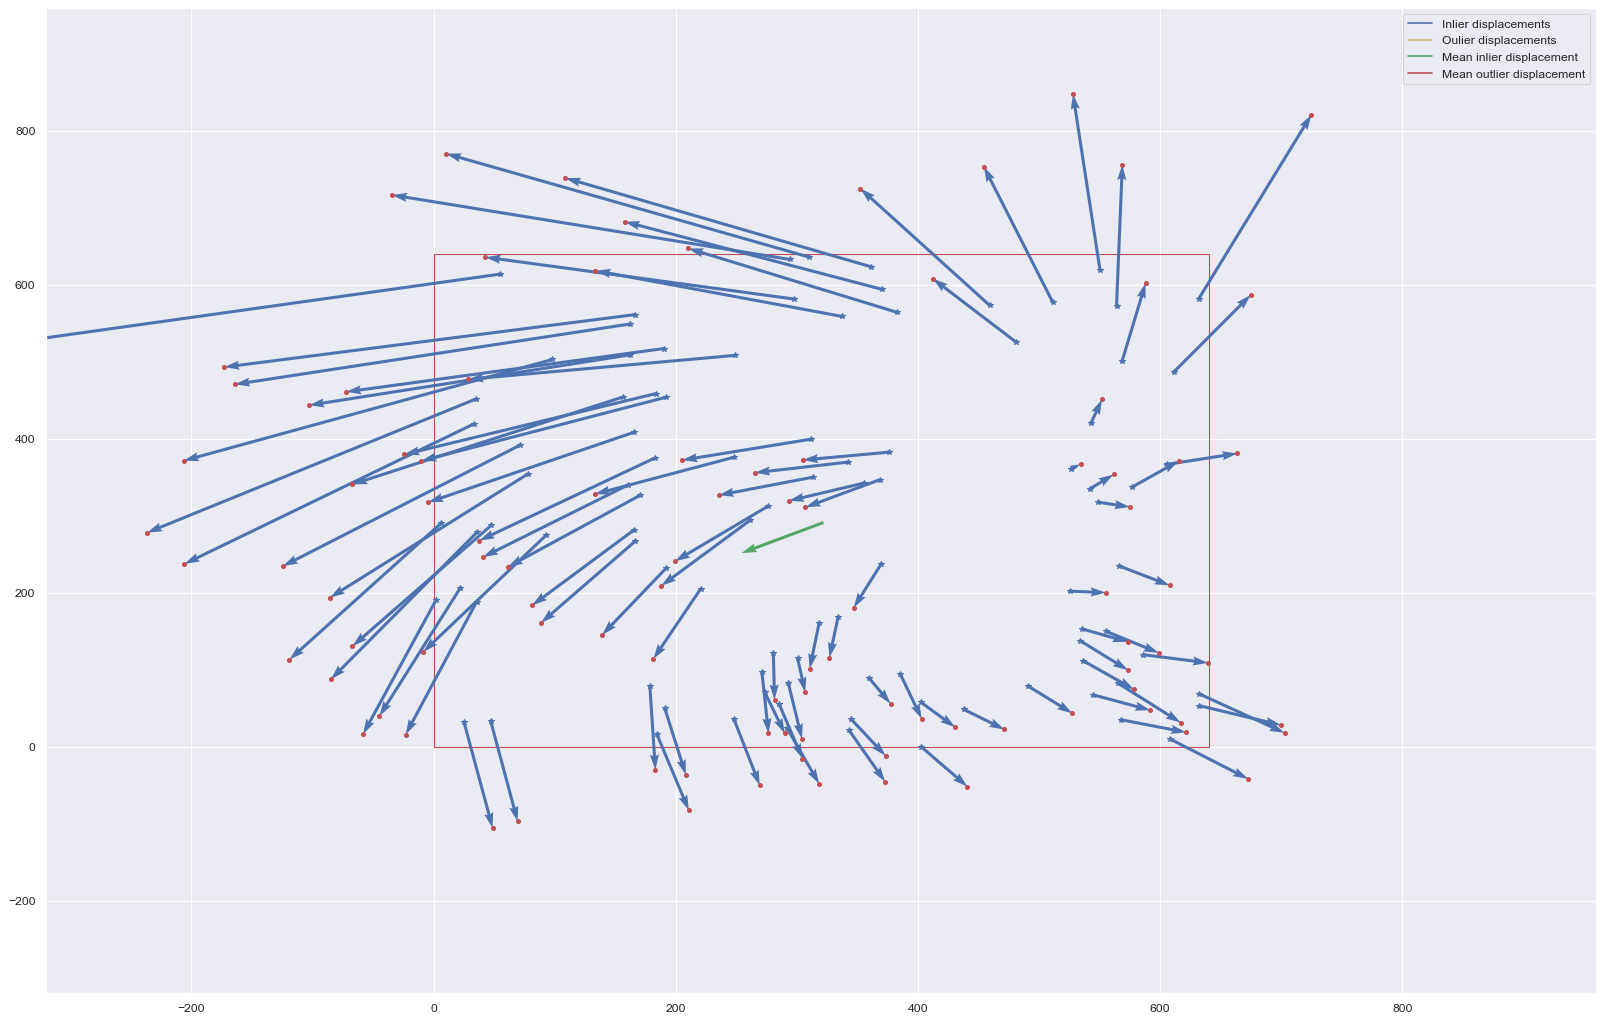

In [10]:
gt, proj, disp, inlier_disp, y_gen, y_pred, generated_from_inliers = get_displacements(100, (0, 30), points_for_solver="min-dist")
print(f"[{generated_from_inliers}] y_gen angle is: {y_gen}, y_pred: {y_pred}")
plot_displacements(gt, proj, inlier_disp, conf)

In [11]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

In [51]:
def get_norm_of_disp(gt, proj):
    vec = (proj - gt)
    return (-vec[1], vec[0])

from scipy.spatial.transform import Rotation
def get_center_of_rotation(gt1, proj1, gt2, proj2):
    n1, n2 = get_norm_of_disp(gt1, proj1), get_norm_of_disp(gt2, proj2)
    
    first_center = (gt1 + proj1) / 2
    second_center = (gt2 + proj2) / 2
    
    c = get_intersect(
        first_center,
        first_center + n1,
        second_center,
        second_center + n2,
    )
    
    
    return c

def get_rotation(gt1, proj1, gt2, proj2, c):
    cgt1 = gt1 - c
    cproj1 = proj1 - c

    cgt2 = gt2 - c
    cproj2 = proj2 - c
    
    
    res = Rotation.align_vectors(
        a=np.array(
            [[*cgt1, 0],
             [*cgt2, 0]]
        ),
        b=np.array(
            [
                [*cproj1, 0],
                [*cproj2, 0]
            ]
        )
    )
    
    return res[0]

In [109]:
def get_rot_angles(gt, proj):
    centers = []
    angles = []
    for _ in range(1000):
        idcs = np.random.choice(len(gt), 2)

        gt1, proj1 = gt[idcs[0]], proj[idcs[0]]
        gt2, proj2 = gt[idcs[1]], proj[idcs[1]]

        c = get_center_of_rotation(gt1.numpy(), proj1.numpy(), gt2.numpy(), proj2.numpy())
        try:
            angle = get_rotation(gt1.numpy(), proj1.numpy(), gt2.numpy(), proj2.numpy(), c)
        except:
            continue
        centers.append(c)
        angles.append(angle)
        
    angles = [-angle.as_euler("XYZ", degrees=True)[2] for angle in angles]
    
    return centers, angles


def get_rot_angles_mean_c(gt, proj):
    centers = []
    indexes = []
    angles = []
    for _ in range(1000):
        idcs = np.random.choice(len(gt), 2)
        indexes.append(idcs)

        gt1, proj1 = gt[idcs[0]], proj[idcs[0]]
        gt2, proj2 = gt[idcs[1]], proj[idcs[1]]

        c = get_center_of_rotation(gt1.numpy(), proj1.numpy(), gt2.numpy(), proj2.numpy())
        centers.append(c)
        
    mean_c = np.array(
        np.median([elm[0] for elm in centers]),
        np.median([elm[1] for elm in centers])
    )
        
    for i in range(1000):
        idcs = indexes[i]
        
        gt1, proj1 = gt[idcs[0]], proj[idcs[0]]
        gt2, proj2 = gt[idcs[1]], proj[idcs[1]]
        
        try:
            angle = get_rotation(gt1.numpy(), proj1.numpy(), gt2.numpy(), proj2.numpy(), mean_c)
        except:
            continue
            
        angles.append(angle)
        
    angles = [-angle.as_euler("XYZ", degrees=True)[2] for angle in angles]
    
    return centers, angles

[True] y_gen angle is: tensor([66.]), y_pred: 64.04927065584022


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


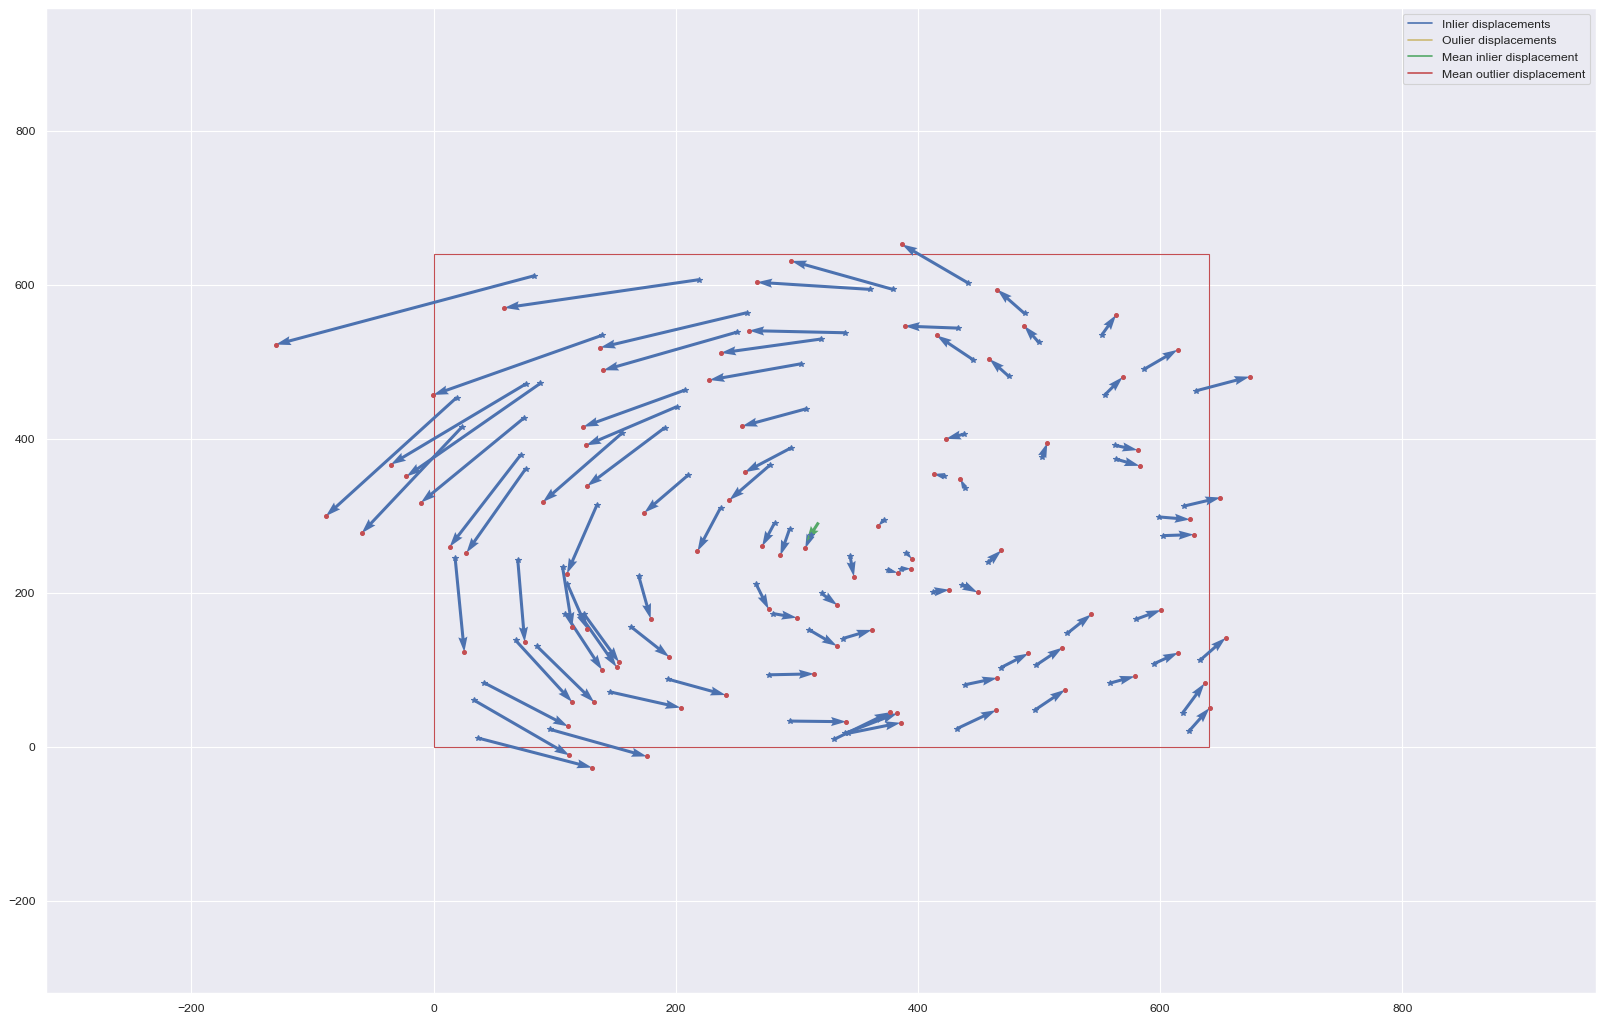

In [97]:
gt, proj, disp, inlier_disp, y_gen, y_pred, generated_from_inliers = get_displacements(100, (0, 30), points_for_solver="min-dist")
print(f"[{generated_from_inliers}] y_gen angle is: {y_gen}, y_pred: {y_pred}")
plot_displacements(gt, proj, inlier_disp, conf)

In [102]:
centers, angles = get_rot_angles(gt, proj)


100%|██████████| 984/984 [00:00<00:00, 14695.32it/s]


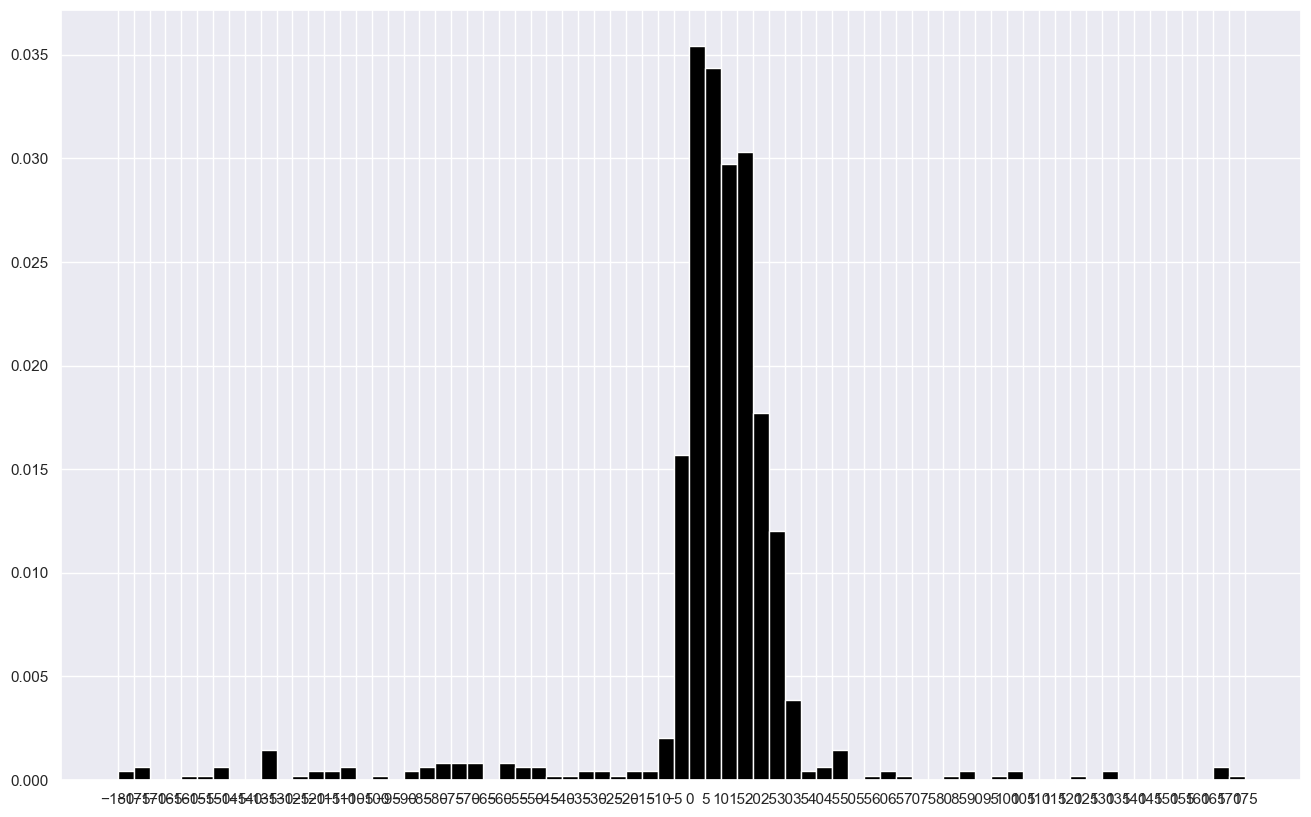

In [103]:
plt.hist(angles, density=True, color='black', bins=np.arange(-180, 180, 5))
plt.xticks(range(-180, 180, 5))
plt.show()

In [100]:
centers, angles = get_rot_angles_mean_c(gt, proj)

<ipython-input-51-ab2258c5e3fe>:30: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  res = Rotation.align_vectors(

100%|██████████| 1000/1000 [00:00<00:00, 14740.54it/s]


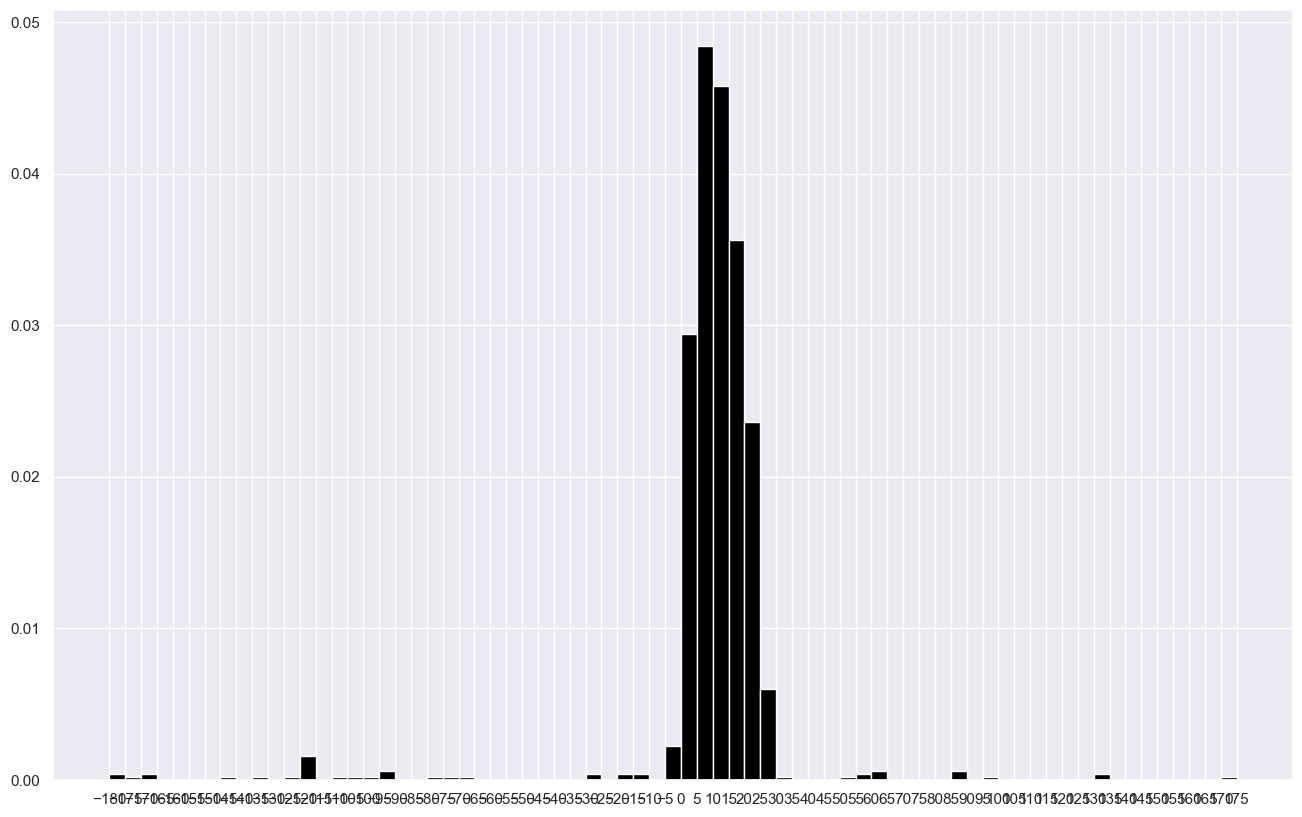

In [101]:
plt.hist(angles, density=True, color='black', bins=np.arange(-180, 180, 5))
plt.xticks(range(-180, 180, 5))
plt.show()

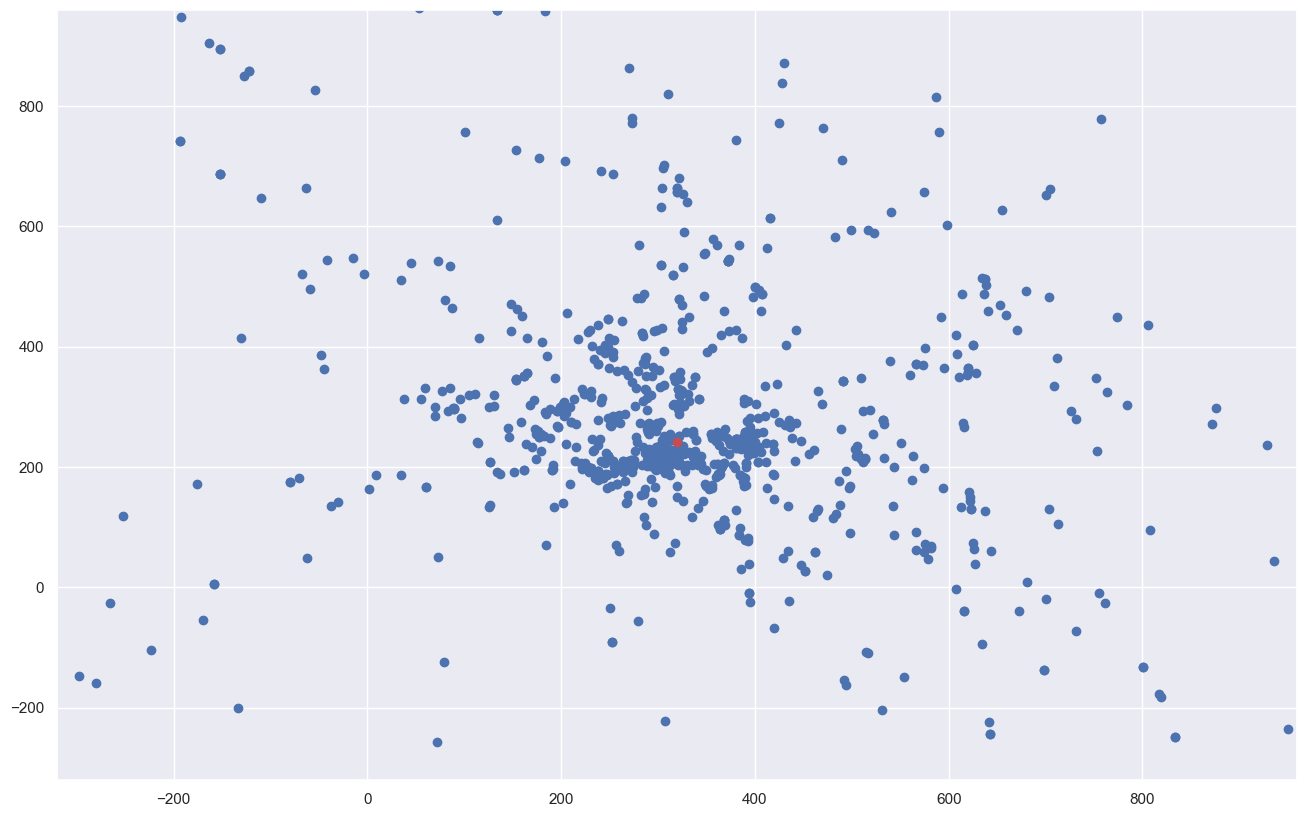

In [104]:
plt.scatter([elm[0] for elm in centers], [elm[1] for elm in centers])
plt.scatter(np.median([elm[0] for elm in centers]), np.median([elm[1] for elm in centers]), color="r")
plt.xlim(-0.5 * conf.img_width, 1.5 * conf.img_width)
plt.ylim(-0.5 * conf.img_height, 1.5 * conf.img_height)
plt.show()

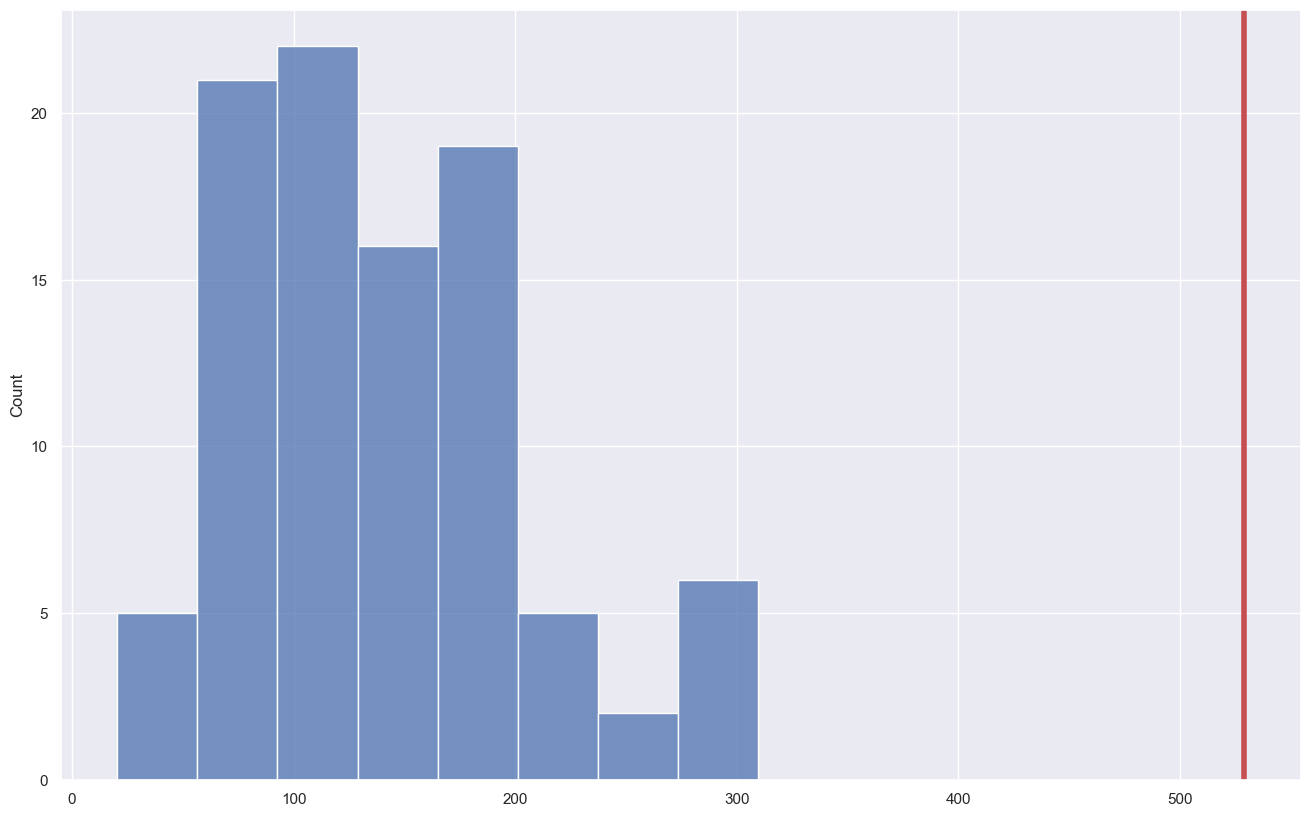

In [18]:
sns.histplot([min(2000, float(elm.norm())) for elm in disp])
plt.axvline(23**2, 0, 1, color='r', linewidth=4)
plt.show()

In [141]:
def get_stats_on_est(steps: int = 100, z_dev: float = 30):
    est = []

    for i in tqdm(range(steps)):
        gt, proj, disp, inlier_disp, y_gen, y_pred, generated_from_inliers = get_displacements(100, (0, z_dev), points_for_solver="min-dist")
        centers, angles = get_rot_angles(gt, proj)
        counts = np.bincount([angle + 180.0 for angle in angles])
        estimated = np.argmax(counts)
        est.append(estimated)

    return est

def get_stats_on_est_mean_center(steps: int = 100, z_dev: float = 30):
    est = []

    for i in tqdm(range(steps)):
        gt, proj, disp, inlier_disp, y_gen, y_pred, generated_from_inliers = get_displacements(100, (0, z_dev), points_for_solver="min-dist")
        centers, angles = get_rot_angles_mean_c(gt, proj)
        counts = np.bincount([angle + 180.0 for angle in angles])
        estimated = np.argmax(counts)
        est.append(estimated)

    return est

In [111]:
est = get_stats_on_est(steps=100, z_dev=30)


100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


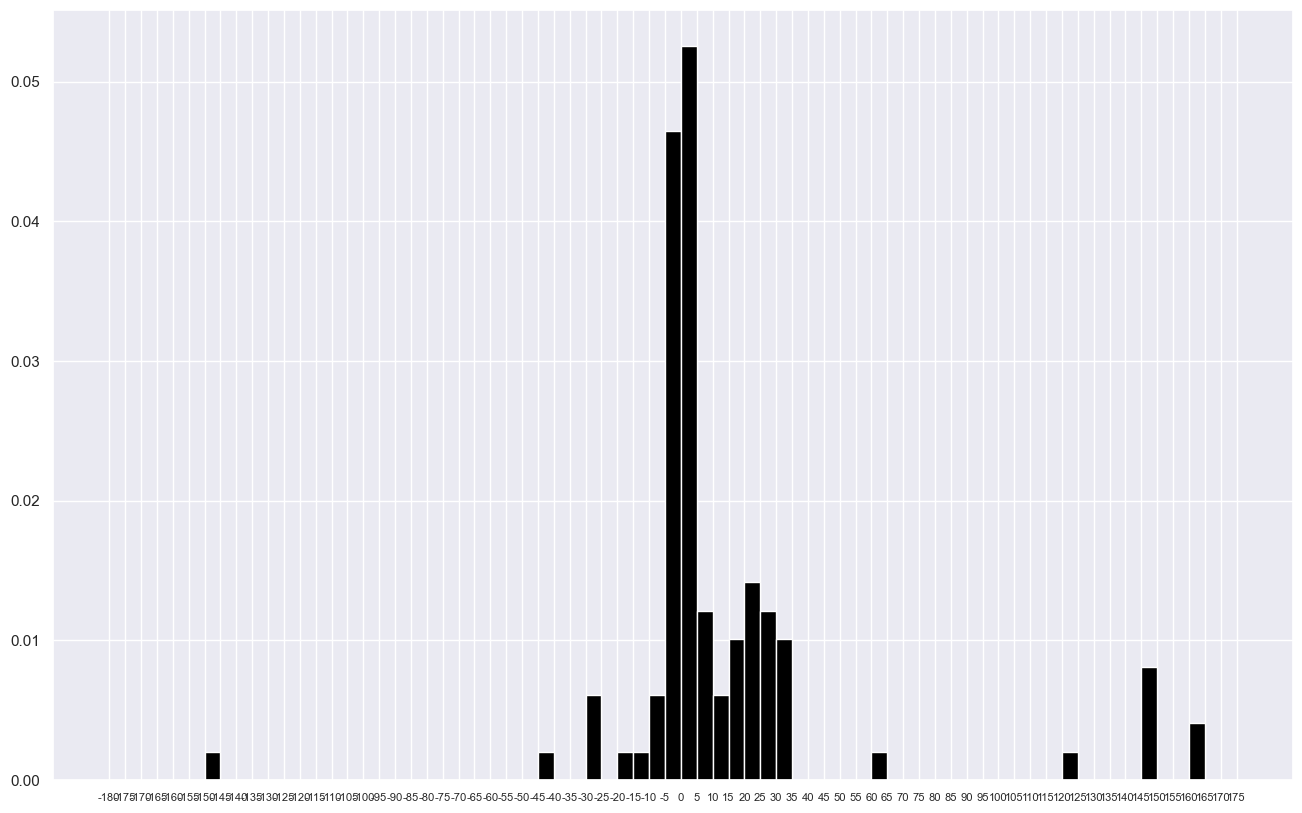

In [140]:
fig, ax = plt.subplots(1, 1)
ax.hist(est, density=True, color='black', bins=np.arange(0, 360, 5))
plt.xticks(range(0, 360, 5), fontsize=8)
ax.set_xticklabels(range(-180, 180, 5))
plt.show()

In [142]:
est = get_stats_on_est_mean_center(steps=100, z_dev=30)

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-51-ab2258c5e3fe>:30: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  res = Rotation.align_vectors(
100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


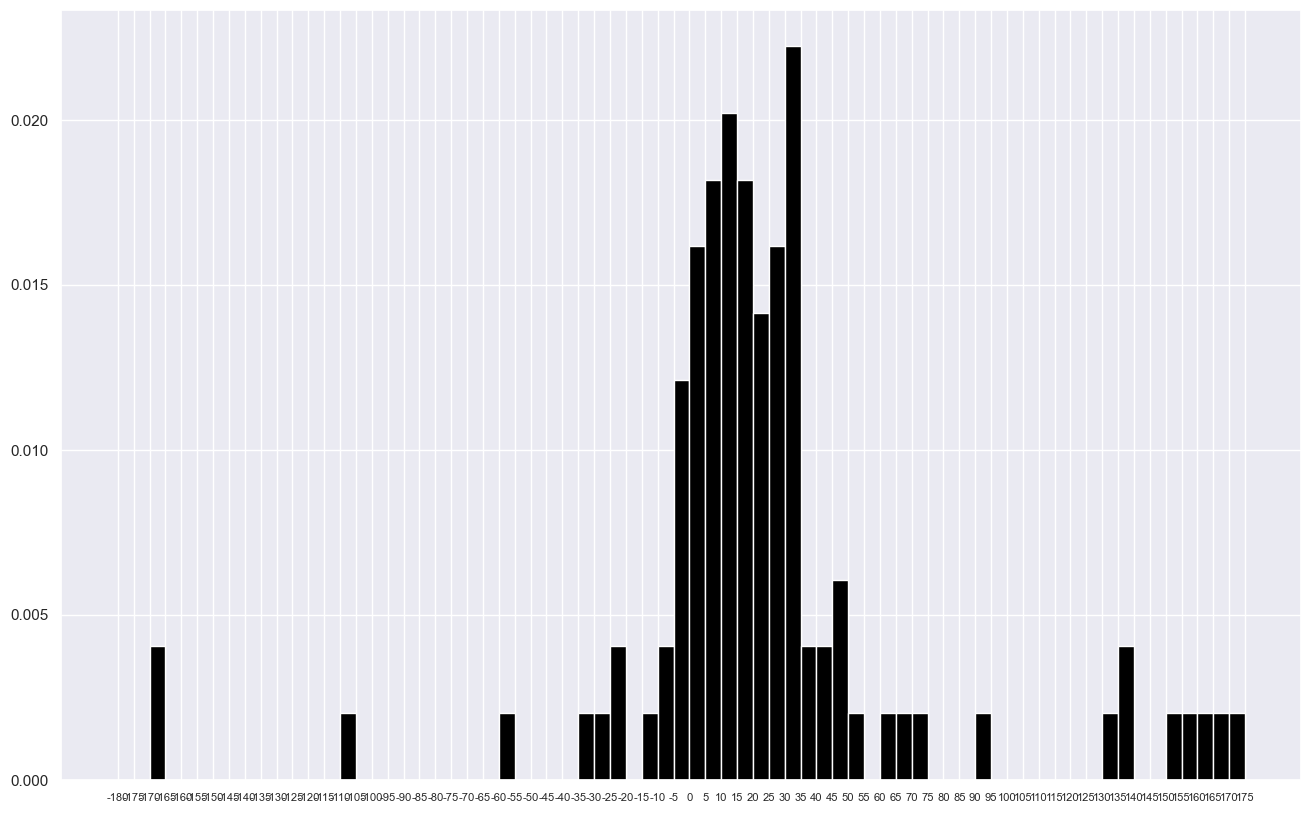

In [143]:
fig, ax = plt.subplots(1, 1)
ax.hist(est, density=True, color='black', bins=np.arange(0, 360, 5))
plt.xticks(range(0, 360, 5), fontsize=8)
ax.set_xticklabels(range(-180, 180, 5))
plt.show()

## What should we see?

In [30]:
conf = Config()
print(conf)

Config(max_depth=1.1, img_width=640, img_height=640, focal_length=554.2562584220409, min_depth=1.0, inliers_ratio=1.0, outlier_dist=30.0, pixel_noise=0.0)


In [31]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

def generate_grid_points(n: int = 3, disp: Tuple[float, float] = (0, 0),
                         c: bool = False,
                         conf: Config = conf,
                         device: torch.device = device,
                         dtype: torch.dtype = dtype):
    x = np.linspace(conf.img_width // n,
                    conf.img_width - conf.img_width // n, n)
    y = np.linspace(conf.img_height // n,
                    conf.img_height - conf.img_height // n, n)
    
    xx, yy = np.meshgrid(x, y)
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), dpi=80)
    axes.plot(xx, yy, marker='.', color='k', linestyle='none')
    
    xs, Xs = [], []
    for i in range(n):
        for j in range(n):
            xs.append((xx[i][j], yy[i][j]))

    
    R = get_upward_with_dev(0, 0, 0, device, dtype)
    Rerr = get_upward_with_dev(0, disp[0], disp[1], device, dtype)
    t = torch.zeros(3, )
    
    for x in xs:
        X = generate_correspondence(torch.tensor(x), conf)
        X = transform_correspondence(X, R, t)
        Xs.append(X)

    reprojected = []
    for X in Xs:
        x = reproject(X, Rerr, t, conf)
        reprojected.append(tuple(x.detach().cpu().numpy()))
    
    xx, yy = np.array([elm[0] for elm in xs]), np.array([elm[1] for elm in xs])
    xxb, yyb = np.array([elm[0] for elm in reprojected]), np.array([elm[1] for elm in reprojected])
    
    axes.plot(xxb, yyb, marker='.', color='r', linestyle='none')
    
    norm = Normalize()
    norm.autoscale(np.arange(len(xx)))
    colormap = cm.inferno

    axes.quiver(xx, yy, xxb - xx, yyb - yy,
                           color=colormap(norm(np.arange(len(xx)))),
                           units='xy',
                           angles='xy',
                           scale_units='xy',
                           scale=1,
                           width=1,
                          )
    
    plt.show()
    

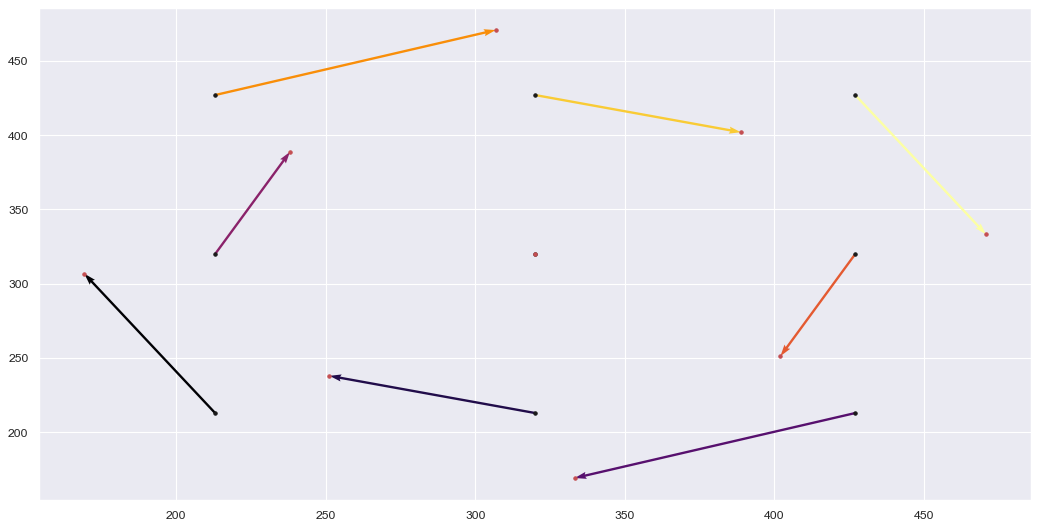

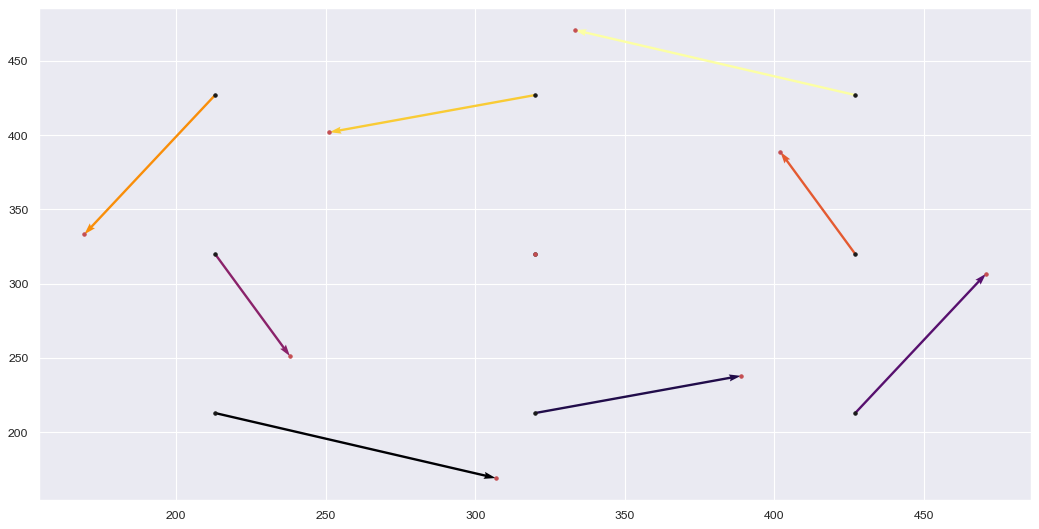

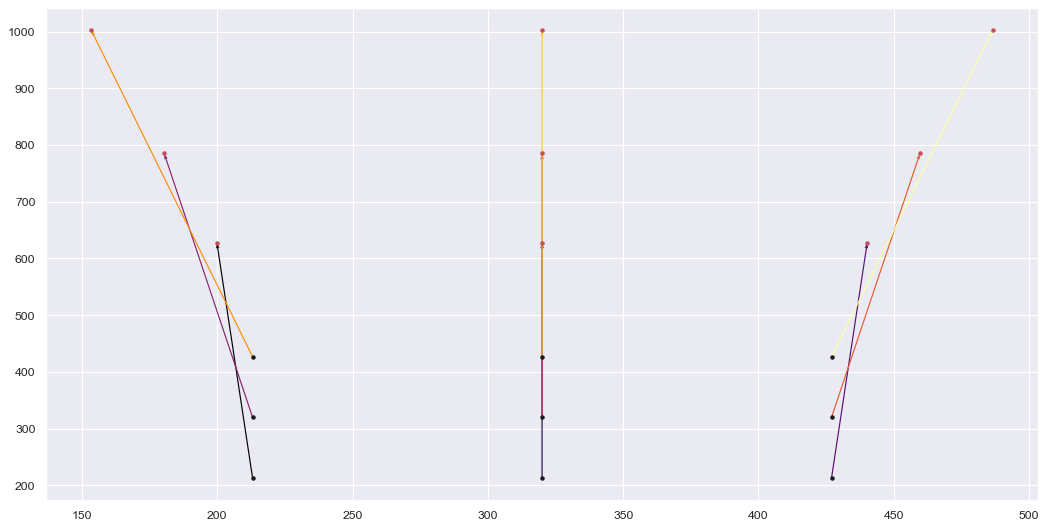

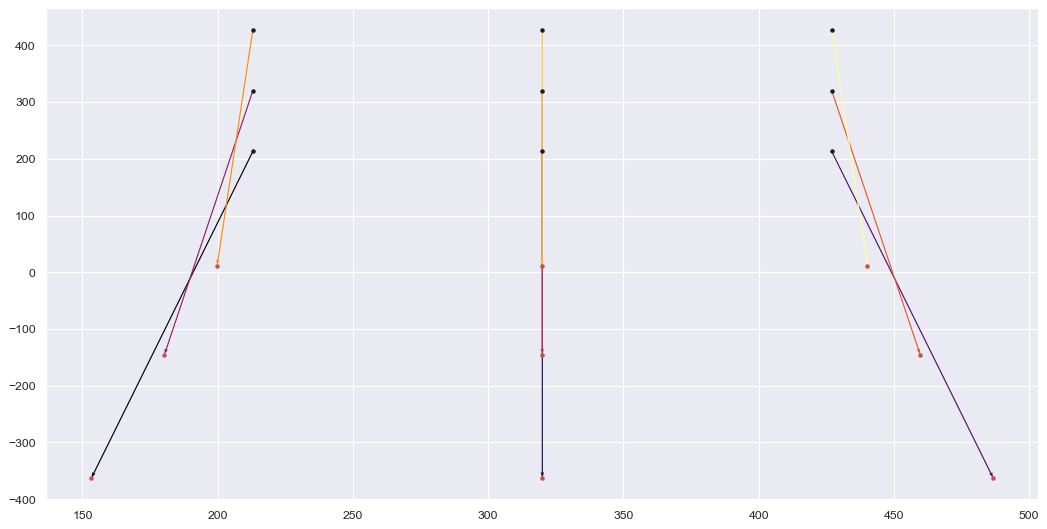

In [32]:
# for disp in [(0, 0.1), (0, -0.1), (0.1, 0), (-0.1, 0)]:
for disp in [(0, 40), (0, -40), (40, 0), (-40, 0)]:
    generate_grid_points(n=3, disp=disp)